<a href="https://colab.research.google.com/github/abuhurera8320/Hate_Speech_Detection/blob/main/Roman_Urdu_Hate_Speech_Detection(Multi_Class).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import Conv1D,LSTM,Dense,Embedding,RepeatVector,TimeDistributed,Bidirectional,GRU,SimpleRNN
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
from IPython.display import Markdown, display
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [3]:
df=pd.read_csv('/content/drive/MyDrive/FYP /MDDLS.csv')

In [4]:
df.shape

(18420, 3)

In [5]:
df['Labels'].unique()

array([0, 2, 3, 4, 1])

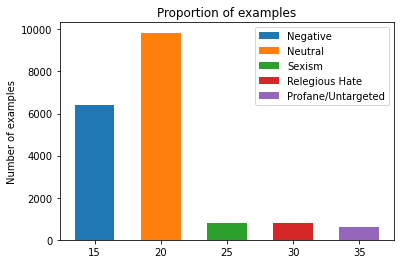

In [6]:
Neu = df[df['Labels'] == 1].shape[0]
Neg = df[df['Labels'] == 0].shape[0]
RH = df[df['Labels'] == 2].shape[0]
Sm = df[df['Labels'] == 3].shape[0]
Profane = df[df['Labels'] == 4].shape[0]
# bar plot of the 3 classes
plt.bar(15,Neg,3, label="Negative")
plt.bar(20,Neu,3, label="Neutral")
plt.bar(25,Sm,3, label="Sexism")
plt.bar(30,RH,3, label="Relegious Hate")
plt.bar(35,Profane,3, label="Profane/Untargeted")
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

## Data Preprocessing
#### 1. Removing Punctuations
#### 2. Converting to Lower case
#### 3. Removing stopwords


In [7]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
import re
def remove_punct(text):
    ''' Input parameter:
    text: (str)
    this method is used to take each text line and check the characters if it
    contains any puntuation and then remove them with blank space'''  
    text  = "".join([char for [char] in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text


In [9]:
# removing all the punctuation
df['Text'] = df['Text'].apply(lambda x: remove_punct(str(x))) 

In [10]:
def convert_to_lower_case(text):
    ''' Input parameter:
    text: (str)
    this method is used to take each text line and converts the characters  into lower case and joins them further'''
    text  = "".join([char.lower() for [char] in text if char not in string.punctuation])
    return text


In [11]:
df['Text'] = df['Text'].apply(lambda x: convert_to_lower_case(str(x))) #calling lower case on each line

In [12]:
stopwords=['ai', 'ayi', 'hy', 'hai', 'main', 'ki', 'tha', 'koi', 'ko', 'sy', 'woh', 'bhi', 'aur', 'wo', 'yeh', 'rha', 
           'hota', 'ho', 'ga', 'ka', 'le', 'lye', 'kr', 'kar', 'lye', 'liye', 'hotay', 'waisay', 'gya', 'gaya', 'kch',
           'ab', 'thy', 'thay', 'houn', 'hain', 'han', 'to','is', 'hi', 'jo', 'kya', 'thi', 'se', 'pe', 'phr', 'wala',
           'waisay', 'us', 'na', 'ny', 'hun', 'rha', 'raha', 'ja', 'rahay', 'abi', 'uski', 'ne', 'haan', 'acha', 'nai',
           'sent', 'you', 'kafi', 'gai', 'rhy', 'kuch', 'jata', 'aye', 'ya', 'dono', 'hoa', 'aese', 'de', 'wohi',
           'jati', 'jb', 'krta', 'lg', 'rahi', 'hui', 'karna', 'krna', 'gi', 'hova', 'yehi', 'jana', 'jye', 'chal', 'mil',
           'tu', 'hum', 'par', 'hay', 'kis', 'sb', 'gy', 'dain', 'krny', 'tou','h','je','or','jee','he','in','un','kay','ki','ya','ap','meri','me']


In [13]:
dictStopWords = {} # global variable
forFastTextData = []
def removeStopWordss(text):
    text = re.sub('[^a-zA-Z]',' ',str(text))
    text = text.lower()
    wordList =str(text).split()
    for word in wordList:
        if word in stopwords:
            wordList.remove(word)
            if word not in dictStopWords:
                dictStopWords[word]= 1
            else:
                dictStopWords[word] = dictStopWords[word] + 1
    newSentence = " ".join(wordList)
    forFastTextData.append(newSentence.split())
    return (newSentence)

In [14]:
df['Text'] = df['Text'].apply(lambda x: removeStopWordss(x)) # sentence with removed stop words

In [15]:
## checking for most common stopwords from the dictionary
import collections
from collections import Counter
dictGraph = {}
d = Counter(dictStopWords) # creating a counter 
d.most_common(10) 
for k,v in d.most_common(10):
    dictGraph[k] = v
dictGraph

{'hai': 4897,
 'ki': 4408,
 'ko': 3615,
 'ka': 2978,
 'to': 2726,
 'ho': 2305,
 'se': 2251,
 'hain': 1552,
 'me': 1450,
 'na': 1423}

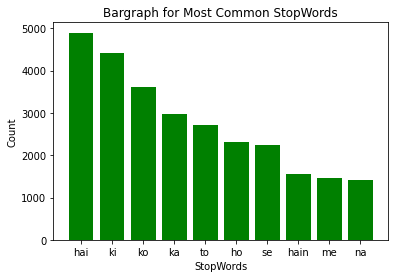

In [16]:
#plotting a graph of 10 most common stopwords from dictionary
plt.bar(dictGraph.keys(), dictGraph.values(), align='center', color = 'green')
plt.title('Bargraph for Most Common StopWords')
plt.xlabel('StopWords')
plt.ylabel('Count')
plt.show()

Tokenization and Test Train Split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X=df['Text']
y=df['Labels']
X.shape

(18420,)

In [19]:
count = df['Text'].str.split().apply(len)
count=count.sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
MAX_SEQUENCE_LENGTH=count.iloc[0]+10
MAX_SEQUENCE_LENGTH

66

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 22847


In [21]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [22]:

X_train = pad_sequences((tokenizer.texts_to_sequences(X_train)),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                      maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (14736, 66)
Testing X Shape: (3684, 66)


In [23]:
print(f'train data:{X_train.shape}, train labels:{y_train.shape},test data:{X_test.shape}, test labels:{y_test.shape}')

train data:(14736, 66), train labels:(14736,),test data:(3684, 66), test labels:(3684,)


## Importing Pretrained Word2vec embeddings

In [24]:
# load embeding for text file
embeddings_index1 = dict()
f = open('/content/drive/MyDrive/FYP /vectors500000.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index1[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index1))

Loaded 31308 word vectors.


In [25]:
# load embeding for text file
embeddings_index2 = dict()
f = open('/content/drive/MyDrive/FYP /word2vec_RU.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index2[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index2))

Loaded 20838 word vectors.


In [26]:
count=0
wordcount1=0
wordcount2=0
dims=100
flag=1
#word_index = {w: i for i, w in enumerate(embeddings_index, 1)}
embedding_matrix = np.zeros((len(word_index)+1, dims))
for word, i in word_index.items():
  if word in embeddings_index1.keys():
    embedding_vector = embeddings_index1.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[:dims]
        wordcount1 +=1
        
  elif word in embeddings_index2.keys():
        embedding_vector = embeddings_index2.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
         embedding_matrix[i] = embedding_vector[:dims]
         wordcount2 +=1
        
  else:
     count +=1
     
      

In [27]:
print('Embedding Stats :')
print(f'Words found in first embedding: {wordcount1}')
print(f'Words found in second embedding: {wordcount2}')
print(f'Words not found in any embedding: {count}')
print(f'Total words found in both embeddings: {wordcount1+wordcount2}')

Embedding Stats :
Words found in first embedding: 10101
Words found in second embedding: 11237
Words not found in any embedding: 1508
Total words found in both embeddings: 21338


In [28]:
embedding_matrix.shape

(22847, 100)

In [29]:
no_of_classes = len(df['Labels'].unique())
no_of_classes

5

##**Simple RNN's**

In [30]:
#%%time
#with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))
model.add(Dropout(0.2))
model.add(SimpleRNN(20))
model.add(Dropout(0.2))
model.add(Dense(200,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(no_of_classes, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 100)           2284700   
                                                                 
 dropout (Dropout)           (None, 66, 100)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20)                2420      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 200)               4200      
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 5)                 5

In [31]:
history=model.fit(X_train, y_train, epochs=5, batch_size=128,validation_data=(X_test, y_test),verbose=1)

Epoch 1/5
116/116 [==============================] - 12s 61ms/step - loss: 1.1241 - accuracy: 0.5213 - val_loss: 1.0733 - val_accuracy: 0.5592
Epoch 2/5
116/116 [==============================] - 12s 103ms/step - loss: 1.0795 - accuracy: 0.5405 - val_loss: 1.0596 - val_accuracy: 0.5736
Epoch 3/5
116/116 [==============================] - 11s 95ms/step - loss: 1.0705 - accuracy: 0.5476 - val_loss: 1.0570 - val_accuracy: 0.5662
Epoch 4/5
116/116 [==============================] - 7s 62ms/step - loss: 1.0643 - accuracy: 0.5501 - val_loss: 1.0381 - val_accuracy: 0.5793
Epoch 5/5
116/116 [==============================] - 7s 58ms/step - loss: 1.0573 - accuracy: 0.5521 - val_loss: 1.0326 - val_accuracy: 0.5839


In [33]:
from sklearn import metrics
def decode_sentiment(score):
    return 1 if score>0.5 else 0

In [34]:
y_pred = model.predict(X_test)
print(y_pred.shape)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape)
metrics.accuracy_score(y_test, y_pred)

(3684, 5)
(3684,)


0.5838762214983714

In [35]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.55      0.22      0.31      1220
           1       0.59      0.94      0.72      2017
           2       0.00      0.00      0.00       176
           3       0.00      0.00      0.00       160
           4       0.00      0.00      0.00       111

    accuracy                           0.58      3684
   macro avg       0.23      0.23      0.21      3684
weighted avg       0.50      0.58      0.50      3684



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
print("confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))

confusion matrix: 
[[ 263  957    0    0    0]
 [ 129 1888    0    0    0]
 [  29  147    0    0    0]
 [  32  128    0    0    0]
 [  29   82    0    0    0]]


Text(0.5, 1.0, 'Loss evolution')

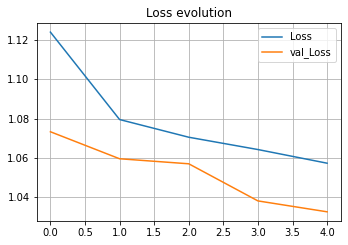

In [37]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')


Text(0.5, 1.0, 'Accuracy evolution')

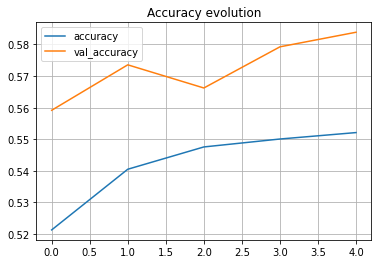

In [38]:
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

## **Bi-Directional LSTM**

In [39]:

model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))

#model.add(Dropout(0.25))
#model.add(Conv1D(128, 3, activation='relu'))
model.add(Bidirectional(LSTM(300)))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(no_of_classes,activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss',verbose = 1)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 66, 100)           2284700   
                                                                 
 bidirectional (Bidirectiona  (None, 600)              962400    
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 512)               307712    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 3,687,425
Trainable params: 1,402,725
Non-trainable params: 2,284,700
____________________________________

In [40]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
116/116 [==============================] - 9s 34ms/step - loss: 0.9585 - accuracy: 0.6433 - val_loss: 0.8069 - val_accuracy: 0.7210
Epoch 2/10
116/116 [==============================] - 3s 26ms/step - loss: 0.6602 - accuracy: 0.7721 - val_loss: 0.7753 - val_accuracy: 0.7560
Epoch 3/10
116/116 [==============================] - 3s 26ms/step - loss: 0.4953 - accuracy: 0.8158 - val_loss: 0.7595 - val_accuracy: 0.7641
Epoch 4/10
116/116 [==============================] - 3s 26ms/step - loss: 0.4173 - accuracy: 0.8313 - val_loss: 0.8012 - val_accuracy: 0.7625
Epoch 5/10
116/116 [==============================] - 3s 26ms/step - loss: 0.3475 - accuracy: 0.8472 - val_loss: 0.8293 - val_accuracy: 0.7676
Epoch 6/10
116/116 [==============================] - 3s 27ms/step - loss: 0.3107 - accuracy: 0.8496 - val_loss: 0.8578 - val_accuracy: 0.7723
Epoch 7/10
116/116 [==============================] - 3s 26ms/step - loss: 0.3275 - accuracy: 0.8441 - val_loss: 0.8384 - val_accuracy: 0.7693

In [41]:
y_pred = model.predict(X_test)
print(y_pred.shape)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape)
accuracy=metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy of Bi-Lstm is {accuracy:.2f}%')

(3684, 5)
(3684,)
Accuracy of Bi-Lstm is 0.75%


In [42]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67      1220
           1       0.90      0.95      0.93      2017
           2       0.09      0.05      0.06       176
           3       0.06      0.04      0.05       160
           4       0.01      0.01      0.01       111

    accuracy                           0.75      3684
   macro avg       0.34      0.35      0.34      3684
weighted avg       0.72      0.75      0.74      3684



In [43]:
print("confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))

confusion matrix: 
[[ 839  142   76   90   73]
 [  89 1926    0    1    1]
 [ 137   25    8    2    4]
 [ 127   23    3    6    1]
 [  92   15    2    1    1]]


Text(0.5, 1.0, 'Loss evolution')

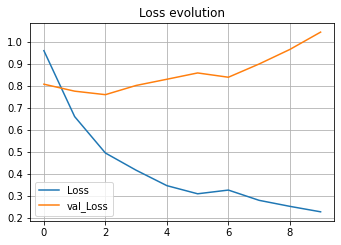

In [44]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy evolution')

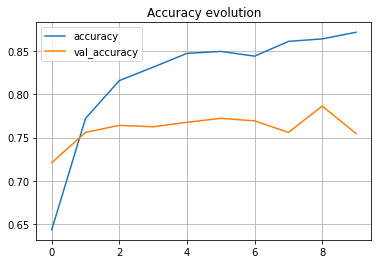

In [45]:
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

# **GRU's**

In [48]:
   # GRU with Word2Vec embeddings and two dense layers
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))
#model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(GRU(300,dropout=0.3)))
model.add(Dense(512,activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(no_of_classes, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 66, 100)           2284700   
                                                                 
 bidirectional_2 (Bidirectio  (None, 600)              723600    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 512)               307712    
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 3,448,625
Trainable params: 1,163,925
Non-trainable params: 2,284,700
____________________________________

In [49]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
231/231 [==============================] - 7s 19ms/step - loss: 1.0522 - accuracy: 0.5790 - val_loss: 0.9708 - val_accuracy: 0.6330
Epoch 2/10
231/231 [==============================] - 4s 16ms/step - loss: 0.9661 - accuracy: 0.6181 - val_loss: 0.9281 - val_accuracy: 0.6596
Epoch 3/10
231/231 [==============================] - 4s 17ms/step - loss: 0.9200 - accuracy: 0.6458 - val_loss: 0.8961 - val_accuracy: 0.6740
Epoch 4/10
231/231 [==============================] - 4s 16ms/step - loss: 0.8931 - accuracy: 0.6596 - val_loss: 0.8828 - val_accuracy: 0.6895
Epoch 5/10
231/231 [==============================] - 4s 17ms/step - loss: 0.8702 - accuracy: 0.6701 - val_loss: 0.8517 - val_accuracy: 0.6916
Epoch 6/10
231/231 [==============================] - 5s 20ms/step - loss: 0.8555 - accuracy: 0.6760 - val_loss: 0.8389 - val_accuracy: 0.7049
Epoch 7/10
231/231 [==============================] - 4s 16ms/step - loss: 0.8277 - accuracy: 0.6846 - val_loss: 0.8392 - val_accuracy: 0.7077

In [50]:
y_pred = model.predict(X_test)
print(y_pred.shape)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape)
accuracy=metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy of Bi-GRU is {accuracy:.2f}%')

(3684, 5)
(3684,)
Accuracy of Bi-GRU is 0.71%


In [51]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.65      0.61      0.63      1220
           1       0.75      0.93      0.83      2017
           2       0.18      0.02      0.04       176
           3       0.00      0.00      0.00       160
           4       0.00      0.00      0.00       111

    accuracy                           0.71      3684
   macro avg       0.32      0.31      0.30      3684
weighted avg       0.63      0.71      0.66      3684



In [52]:
print("confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))

confusion matrix: 
[[ 749  449   17    2    3]
 [ 144 1872    1    0    0]
 [ 102   70    4    0    0]
 [  87   73    0    0    0]
 [  71   40    0    0    0]]


Text(0.5, 1.0, 'Loss evolution')

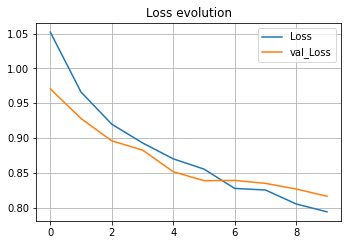

In [53]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy evolution')

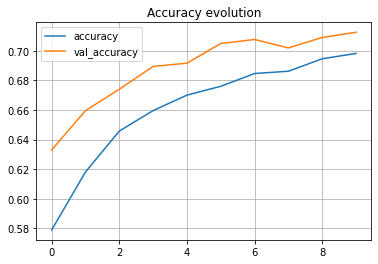

In [54]:
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')